In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import apache_beam as beam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from apache_beam import dataframe
from apache_beam.ml.inference.base import RunInference, PredictionResult
from apache_beam.ml.inference.sklearn_inference import SklearnModelHandlerNumpy
from apache_beam.ml.inference.sklearn_inference import ModelFileType
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerTensor, _convert_to_result
from apache_beam.ml.inference.base import KeyedModelHandler
from autoembedder import Autoembedder
import apache_beam.runners.interactive.interactive_beam as ib


data = pd.read_csv('dtc_opportunity.csv')

In [9]:
data['Created Date'] = pd.to_datetime(data['Created Date'], format='%Y-%m-%dT%H:%M:%S.%f').dt.tz_localize(None)
data['Close Date'] = pd.to_datetime(data['Close Date'], format='%m/%d/%y').dt.tz_localize(None)
data['Opportunity Duration Days'] = data['Close Date'] - data['Created Date']
data['Opportunity Duration Days'] = data['Opportunity Duration Days'].dt.days

In [10]:
data.isna().sum()

Opportunity Name               0
Billing State/Province       392
Account Type                   0
Account Owner                  0
Product Name                  97
Amount                         0
#                              0
Account Name                   0
Billing Country                0
Close Date                     0
Closed                         0
Created Date                   0
Forecast Category              0
Industry                       0
Opportunity Owner              0
Opportunity Source             0
Opportunity Type               0
Owner Role                     0
Product Family                97
Segment                        0
Stage                          0
Won                            0
Opportunity Duration Days      0
dtype: int64

In [11]:
data

,Opportunity Name,Billing State/Province,Account Type,Account Owner,Product Name,Amount,#,Account Name,Billing Country,Close Date,...,Industry,Opportunity Owner,Opportunity Source,Opportunity Type,Owner Role,Product Family,Segment,Stage,Won,Opportunity Duration Days
0,Opportunity for White1403,NaN,Partner,Catherine Brown,Certifications,972500,624,West49 Inc,Japan,2020-05-26,...,Apparel,Doroth Gardner,AE,New Business / Add-on,Sales AMER,Digital Media,SMB,09 - Closed Lost,False,1884
1,Opportunity for Gordon1846,ME,Customer,Julie Chavez,Books,1531940,151,Martinez181 Inc,USA,2020-05-28,...,Biotechnology,Harold Campbell,BDR,New Business,Sales EMEA,Digital Media,SMB,08 - Closed Won,True,1921
2,Opportunity for Willis238,NaN,Partner,Julie Chavez,Light laptop,2250950,114,Bush454 Inc,Norway,2020-05-30,...,Finance,Irene Kelley,Alliances,New Business,Sales AMER,Laptops,SMB,08 - Closed Won,True,2067
3,Opportunity for Holt1880,NaN,Partner,Doroth Gardner,Books,950440,225,Ortega682 Inc,Turkey,2020-05-30,...,Telecommunications,Catherine Brown,Alliances,Existing Business,Sales WW,Accessories,SMB,09 - Closed Lost,False,1980
4,Opportunity for Thomas1257,DE,Partner,Bruce Kennedy,Cables,1499560,400,Carlson744 Inc,USA,2020-06-02,...,Banking,Chris Riley,Alliances,New Business / Add-on,Sales EMEA,Accessories,MM,09 - Closed Lost,False,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,Opportunity for Ramirez1837,NaN,Customer,John Williams,NaN,179964,149,Salazar150 Inc,United Kingdom,2022-03-04,...,Utilities,Laura Palmer,Alliances,New Business,Sales EMEA,NaN,SMB,02 - Qualification,False,2058
667,Opportunity for Howard1207,CT,Customer,Laura Garza,NaN,449438,323,Marsh836 Inc,USA,2022-03-04,...,Insurance,Laura Palmer,AE,New Business,Sales EMEA,NaN,SMB,04 - Value Proposition,False,2050
668,Opportunity for Rodriquez958,NaN,Partner,Irene Kelley,Space phone 2,413100,503,Tran514 Inc,Japan,2022-03-06,...,Engineering,Irene McCoy,AE,New Business / Add-on,Sales WW,Phones,ENT,02 - Qualification,False,2066
669,Opportunity for Lyons494,NaN,Customer,John Williams,Light tablet 2,2371900,384,Johnston241 Inc,South Korea,2022-03-12,...,Apparel,Kelly Frazier,Alliances,New Business,Sales EMEA,Laptops,MM,02 - Qualification,False,2035


In [12]:
data = data.dropna()

In [13]:
data.to_csv('tensorflow_regression_opportunity.csv', index=False)

In [14]:
def get_one_hot_encoding(df, col) -> pd.DataFrame:
    beam_df_categorical = df[col]
    with dataframe.allow_non_parallel_operations():
        unique_classes = pd.CategoricalDtype(ib.collect(beam_df_categorical.unique(as_series=True)))
    beam_df_categorical = beam_df_categorical.astype(unique_classes).str.get_dummies()
    beam_df_categorical = beam_df_categorical.add_prefix(f'{col}___')

    return beam_df_categorical

In [15]:
TARGET_COLUMN = {'Opportunity_Duration_Days'}

In [23]:
with beam.Pipeline(InteractiveRunner()) as p:
    input_data = p | "Read CSV" >> beam.dataframe.io.read_csv('tensorflow_regression_opportunity.csv')
    # For now dropping dates
    input_data = input_data.drop(['Billing State/Province',
                                  'Created Date',
                                  'Close Date',
                                  'Account Name',
                                  'Product Name',
                                  'Opportunity Name'], axis=1)
    input_data = input_data.drop('#', axis=1)
    input_data = input_data.replace('-', 'HYPHEN', regex=True)
    input_data = input_data.replace('/', 'SLASH', regex=True)
    input_data = input_data.replace(' ', 'SPACE', regex=True)
    input_data = input_data.rename(columns={x: x.replace(' ', '_') for x in input_data.columns})

    with dataframe.allow_non_parallel_operations():
        input_data = input_data.dropna()

    numerical_cols = set(input_data.select_dtypes(include=np.number).columns.tolist()) - TARGET_COLUMN
    bool_cols = input_data.select_dtypes(include='bool').columns.tolist()
    print(numerical_cols)

    categorical_cols = list(set(input_data.columns) - set(numerical_cols) - set(bool_cols) - TARGET_COLUMN)
    print(categorical_cols)

    input_data_numericals = input_data.filter(items=numerical_cols)
    input_data_numericals = (input_data_numericals - input_data_numericals.mean())/input_data_numericals.std()

    processed_cat_columns = []

    for categorical_col in categorical_cols:
        input_data_categorical = get_one_hot_encoding(df=input_data, col=categorical_col)
        processed_cat_columns.extend(list(input_data_categorical.columns))
        input_data_numericals = input_data_numericals.merge(input_data_categorical, left_index=True, right_index=True)

    for bool_col in bool_cols:
        input_data_numericals = input_data_numericals.merge(input_data[bool_col].astype(int), left_index=True, right_index=True)

    input_data_numericals = input_data_numericals.merge(input_data[list(TARGET_COLUMN)].astype(int), left_index=True, right_index=True)

aa = ib.collect(input_data_numericals)
train = aa.sample(frac=0.8, random_state=42)
test = aa.drop(train.index)
train.to_csv('tensorflow_output_train_final.csv', index=False)
test.to_csv('tensorflow_output_test_final.csv', index=False)

{'Amount'}
['Billing_Country', 'Account_Owner', 'Product_Family', 'Segment', 'Opportunity_Owner', 'Opportunity_Source', 'Forecast_Category', 'Account_Type', 'Stage', 'Opportunity_Type', 'Owner_Role', 'Industry']


C:\Users\Marko\Desktop\Projects\DnA_accelerators\python-runinference\venv\lib\site-packages\apache_beam\dataframe\frame_base.py:145: RuntimeWarning: invalid value encountered in longlong_scalars
  lambda left, right: getattr(left, op)(right), name=op, args=[other])


In [26]:
train_df = pd.read_csv("tensorflow_output_train_final.csv")
test_df = pd.read_csv("tensorflow_output_test_final.csv")

In [27]:
train_df

,Amount,Billing_Country___Canada,Billing_Country___Morocco,Billing_Country___SouthSPACEAfrica,Billing_Country___USA,Billing_Country___nan,Account_Owner___BruceSPACEKennedy,Account_Owner___CatherineSPACEBrown,Account_Owner___ChrisSPACERiley,Account_Owner___DennisSPACEHoward,...,Industry___Media,Industry___Retail,Industry___Technology,Industry___Telecommunications,Industry___Transportation,Industry___Utilities,Industry___nan,Closed,Won,Opportunity_Duration_Days
0,-0.805116,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1880
1,-0.311166,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1978
2,-0.620518,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,2026
3,-0.608800,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,1904
4,-0.934749,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,-0.874416,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2040
185,-0.412580,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1969
186,-0.848785,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1879
187,-0.962945,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,1881


In [43]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop(list(TARGET_COLUMN)[0])
test_labels = test_features.pop(list(TARGET_COLUMN)[0])

In [69]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


In [94]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [103]:
dnn_model = build_and_compile_model()
dnn_model.build(input_shape=train_features.shape)

In [104]:
dnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (189, 64)                 7168      
                                                                 
 dense_52 (Dense)            (189, 64)                 4160      
                                                                 
 dense_53 (Dense)            (189, 1)                  65        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


In [106]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 812 ms
Wall time: 3.41 s


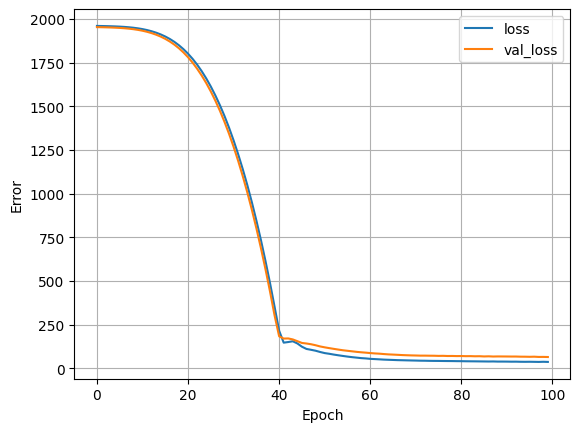

In [107]:
plot_loss(history)

Collect the results on the test set:

In [111]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

75.53707885742188

In [116]:
import tfx_bsl
from apache_beam.ml.inference.base import KeyedModelHandler
from tfx_bsl.public.beam.run_inference import CreateModelHandler

from tfx_bsl.public import tfxio
from tfx_bsl.public.proto import model_spec_pb2

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string , name='examples')])
def serve_tf_examples_fn(serialized_tf_examples):
    """Returns the output to be used in the serving signature."""
    features = tf.io.parse_example(serialized_tf_examples, RAW_DATA_PREDICT_SPEC)
    return model(features, training=False)

signature = {'serving_default': serve_tf_examples_fn}


In [117]:
dnn_model.save('pretrained/tf_regressor')

INFO:tensorflow:Assets written to: pretrained/tf_regressor\assets


INFO:tensorflow:Assets written to: pretrained/tf_regressor\assets


In [121]:
saved_model_spec = model_spec_pb2.SavedModelSpec(model_path='pretrained/tf_regressor')
inference_spec_type = model_spec_pb2.InferenceSpecType(saved_model_spec=saved_model_spec)
model_handler = CreateModelHandler(inference_spec_type)


with beam.Pipeline() as p:
    _ = (p | "Read CSV" >> beam.dataframe.io.read_csv("tensorflow_output_test_final.csv")
         | "Convert to PColl" >> beam.dataframe.convert.to_pcollection()
         | tfx_bsl.public.beam.RunInference(model_handler)
         # | beam.ParDo(FormatOutput())
         | beam.Map(print)
         )


ValueError: Input dtype is expected to be 7, got 1